(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) ()
(27,) (5, 27) 

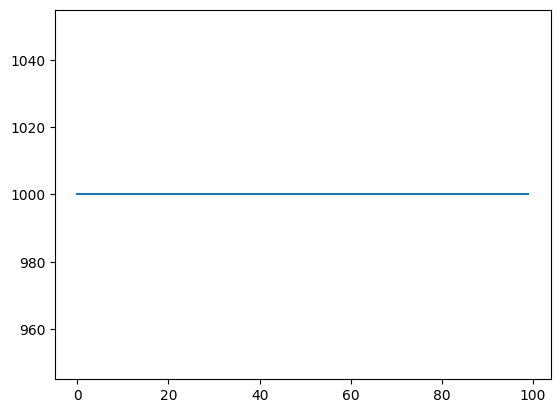

In [15]:
import numpy as np
import enum
import matplotlib.pyplot as plt

# Define the grid size
GRID_SIZE = 10

# Enum for tile types
class TileType(enum.Enum):
    empty = 0
    tree = 1
    log = 2
    
instance_counts : dict[int, int] = {
    TileType.tree.value: 10,
    TileType.log.value: 0
}

# Define the agent class
class Agent:
    def __init__(self):
        self.x = np.random.randint(GRID_SIZE)
        self.y = np.random.randint(GRID_SIZE)
        self.actions = ['up', 'down', 'left', 'right', 'interact']
        self.num_hidden_neurons = 100
        #self.weights_1 = np.random.randn(9 * len(TileType), self.num_hidden_neurons)
        #self.weights_2 = np.random.randn(self.num_hidden_neurons, len(self.actions))
        self.weights_1 = np.random.randn(len(self.actions), 9 * len(TileType))
        #self.thresholds_1 = np.random.rand(self.num_hidden_neurons)
        self.thresholds_1 = np.random.rand(len(self.actions))
        self.theta_open = 1e-2
        self.gamma_th = 1e-2
        self.gamma_w = 1e-2
        
    def step(self, action, grid):
        reward: float = 0.0
        if action == 'up':
            self.y = max(0, self.y - 1)
        elif action == 'down':
            self.y = min(GRID_SIZE - 1, self.y + 1)
        elif action == 'left':
            self.x = max(0, self.x - 1)
        elif action == 'right':
            self.x = min(GRID_SIZE - 1, self.x + 1)
        elif action == 'interact':
            if grid[self.y][self.x] == TileType.tree.value:
                grid[self.y][self.x] = TileType.log.value
                reward += 1.0
        return reward
                
    def select_action(self, visual_field):
        visual_field = visual_field.flatten()
        # Embed the visual field into a one-hot vector
        in_1 = np.zeros((9, len(TileType)))
        for i in range(9):
            in_1[i, visual_field[i]] = 1.0
        in_1 = in_1.flatten()
        
        # Calculate activations
        #hidden_activations = np.linalg.norm(self.weights_1 - in_1, axis=1)
        #firing = hidden_activations < self.thresholds_1
        #min_activated_neuron = np.argmin(hidden_activations)    
        
        # Feed-forward
        # subtract the inputs from each row of the weights matrix
        dist = self.weights_1
        dist[:] -= in_1
        activation = np.linalg.norm(dist)
        active = activation > self.thresholds_1
        
        # Decrease all thresholds by theta_open if no neurons are active
        if not np.any(active):
            self.thresholds_1 -= self.theta_open
            return np.random.choice(self.actions)
        
        # Learning
        delta_threshold = activation - self.thresholds_1
        delta_w = in_1 - self.weights_1
        
        self.thresholds_1 = self.thresholds_1 + self.gamma_th * delta_threshold * active
        self.weights_1 = self.weights_1 + self.gamma_w * delta_w * active
        
        print(in_1.shape, self.weights_1.shape, activation.shape)
        
        # select the action indicated by the minimally activated neuron in the hidden layer
        min_activated_neuron = np.argmin(activation)
        return self.actions[min_activated_neuron]

# Initialize the grid
def init_world():
    grid = np.full((GRID_SIZE, GRID_SIZE), fill_value=TileType.empty.value, dtype=int)
    for tile_type, count in instance_counts.items():
        for i in range(count):
            x = np.random.randint(GRID_SIZE)
            y = np.random.randint(GRID_SIZE)
            grid[y, x] = tile_type
    return grid

# Create the agent
agent = Agent()

def step(grid):
    # Construct the agent's visual field
    visual_field = np.full((GRID_SIZE, GRID_SIZE), fill_value=TileType.empty.value, dtype=int)
    for x in range(agent.x - 1, agent.x + 1):
        for y in range(agent.y - 1, agent.y + 1):
            if x < 0 or x >= GRID_SIZE or y < 0 or y >= GRID_SIZE:
                break
            visual_field[y, x] = grid[y, x]
    
    # Advance the state of the world by one step
    action = agent.select_action(visual_field)
    reward = agent.step(action, grid)
    
    return reward

max_frames: int = 1000
    
def run_simulation_with_rendering():
    import pygame
    grid = init_world()
    pygame.init()
    display_size = (16 * GRID_SIZE, 16 * GRID_SIZE)
    screen = pygame.display.set_mode(display_size, depth=32)
    pygame.display.set_caption('Rimworld AI')
    clock = pygame.time.Clock()
    
    # Load the sprites
    sprite_filenames = {
        TileType.empty.value: 'assets/empty.png',
        TileType.tree.value: 'assets/tree.png',
        TileType.log.value: 'assets/log.png'
    }
    sprites = {}
    for tile_type, filename in sprite_filenames.items():
        try:
            sprites[tile_type] = pygame.image.load(filename).convert_alpha()
        except pygame.error as e:
            print(f"Error loading image: {filename}")
            print(str(e))
            pygame.quit()
            raise SystemExit
    agent_sprite = pygame.image.load('assets/agent.png').convert_alpha()

    done = False
    frame = 0
    reward_history = np.zeros(max_frames)
    
    while not done:
        reward = step(grid)
        reward_history[frame] = reward
        
        screen.fill((255, 255, 255))
        
        # Render the tiles
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                tile = grid[y, x]
                sprite = sprites[tile]
                screen.blit(sprite, (x * 16, y * 16))
                
        # Render the agent
        screen.blit(agent_sprite, (agent.x * 16, agent.y * 16))
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
        pygame.display.flip()
        pygame.display.update()
        clock.tick(30)
        
        # End if time has elapsed
        frame += 1
        if frame == max_frames:
            done = True
        
        # End if all trees are gone
        if is_session_complete(grid):
            done = True

    pygame.quit()

    return reward_history, frame

def run_simulation_without_rendering():
    done = False
    frame = 0
    reward_history = np.zeros(max_frames)
    grid = init_world()
    
    while not done:
        reward = step(grid)
        reward_history[frame] = reward
        
        # End if time has elapsed
        frame += 1
        if frame == max_frames:
            done = True
        
        # End if all trees are gone
        if is_session_complete(grid):
            done = True

    return reward_history, frame

def is_session_complete(grid) -> bool:
    if np.count_nonzero(grid == TileType.tree.value) == 0:
        return True
    return False

num_epochs = 100
epoch_performance = np.zeros(num_epochs)
for epoch in range(num_epochs):
    reward_history, frames = run_simulation_without_rendering()
    epoch_performance[epoch] = frames
    
#reward_history, frame = run_simulation_with_rendering()

fig = plt.figure()
plt.plot(epoch_performance)